In [1]:
from typing import List
import os
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

c:\Users\tnguy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
load_dotenv()

True

In [3]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


#llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY)
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY)
llm_with_tool = llm.bind_tools([PromptInstructions])

chain = get_messages_info | llm_with_tool

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


prompt_gen_chain = get_prompt_messages | llm

In [5]:
from typing import Literal

from langgraph.graph import END


def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, MessageGraph

memory = SqliteSaver.from_conn_string(":memory:")
workflow = MessageGraph()
workflow.add_node("info", chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Prompt generated!", tool_call_id=state[-1].tool_calls[0]["id"]
    )


workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

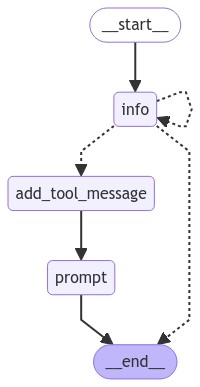

In [7]:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        [HumanMessage(content=user)], config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

Hello! How can I assist you today? Are you looking to create a prompt template? If so, please provide some details about it.
================================== Ai Message ==================================

Great! Let's get started. 

1. What is the objective of the prompt you want to create?
2. What variables will be passed into the prompt template?
3. Are there any constraints for what the output should NOT do?
4. What requirements must the output adhere to?

Please provide this information so I can help you effectively!
================================== Ai Message ==================================

Could you please clarify what you mean by "give me random"? Are you looking for a random prompt template, or do you have specific requirements in mind? Please provide details about the objective, variables, constraints, and requirements for the prompt template you want to create.
AI: Byebye
